In [1]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [3]:
image_folder = "images_mango"
csv_file = "Harumanis_mango_weight.csv"
data = pd.read_csv(csv_file)

In [4]:
# Crear un diccionario con los nombres de imagenes y sus respectivos pesos
image_to_weight = dict(zip(data['no'], data['weight']))

# Listar todas las imágenes en la carpeta
image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]

# Crear una lista para almacenar las imágenes que coinciden con el CSV
matched_images = []

In [5]:
# Recorrer cada imagen en el folder y verificar si está en el CSV
for image_file in image_files:
    if image_file in image_to_weight:
        # Obtener el peso correspondiente de la imagen
        weight = image_to_weight[image_file]
        
        # Leer la imagen usando OpenCV
        image_path = os.path.join(image_folder, image_file)
        image = cv2.imread(image_path)
        
        if image is not None:
            matched_images.append((image_file, image, weight))
        else:
            print(f"No se pudo leer la imagen: {image_file}")

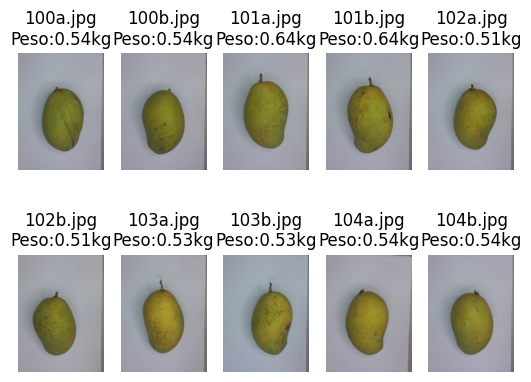

Total de imágenes coincidentes: 546


In [6]:
# Mostrar las primeras 10 imágenes y sus pesos
for i, (image_file, image, weight) in enumerate(matched_images[:10]):
    # Convertir la imagen de BGR a RGB para mostrar correctamente con matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Mostrar la imagen
    plt.subplot(2, 5, i+1)  # Crear una cuadrícula de 2 filas y 5 columnas
    plt.imshow(image_rgb)
    plt.title(f"{image_file}\nPeso:{weight}kg")
    plt.axis('off')  # Ocultar los ejes

# Mostrar las imágenes en una ventana
plt.show()

print(f"Total de imágenes coincidentes: {len(matched_images)}")

In [7]:
import numpy as np
from skimage.feature import hog
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [8]:
# Función para preprocesar la imagen (umbralización, equalización, operaciones morfológicas)
def preprocess_image(image):
    # Convertir la imagen a escala de grises
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Aplicar ecualización del histograma para mejorar el contraste
    equalized_image = cv2.equalizeHist(gray_image)

    # Aplicar umbralización para binarizar la imagen
    _, thresholded_image = cv2.threshold(equalized_image, 128, 255, cv2.THRESH_BINARY)

    # Aplicar operaciones morfológicas para limpiar la imagen (opcional)
    kernel = np.ones((3, 3), np.uint8)
    morphed_image = cv2.morphologyEx(thresholded_image, cv2.MORPH_CLOSE, kernel)

    return morphed_image

In [9]:
# Función para calcular características de una imagen
def extract_features(image):
    # Preprocesar la imagen (umbralización, equalización, operaciones morfológicas)
    processed_image = preprocess_image(image)
    
    # Obtener HOG features
    hog_features, _ = hog(processed_image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    
    # Calcular momentos de la imagen
    moments = cv2.moments(processed_image)
    hu_moments = cv2.HuMoments(moments).flatten()
    
    # Calcular características de forma (excentricidad, compactación)
    contours, _ = cv2.findContours(processed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        cnt = contours[0]
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)
        
        # Verificar que el área sea mayor a 0 antes de calcular compactación
        if area > 0:
            compactness = (perimeter ** 2) / area
        else:
            compactness = 0
        eccentricity = moments['mu20'] / moments['mu02'] if moments['mu02'] != 0 else 0
    else:
        compactness = 0
        eccentricity = 0
    
    # Concatenar todas las características
    return np.hstack([hog_features, hu_moments, compactness, eccentricity])

In [10]:
# Lista para almacenar características y pesos
X = []
y = []

In [11]:
# Recorrer cada imagen en el folder y extraer características
for image_file in image_files:
    if image_file in image_to_weight:
        # Obtener el peso correspondiente de la imagen
        weight = image_to_weight[image_file]
        
        # Leer la imagen usando OpenCV
        image_path = os.path.join(image_folder, image_file)
        image = cv2.imread(image_path)
        
        if image is not None:
            # Extraer características de la imagen
            features = extract_features(image)
            X.append(features)
            y.append(weight)
        else:
            print(f"No se pudo leer la imagen: {image_file}")

In [12]:
# Convertir listas a arrays numpy
X = np.array(X)
y = np.array(y)

In [13]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo de regresión lineal
model = LinearRegression()

# Entrenar el modelo
model.fit(X_train, y_train)

# Hacer predicciones en los datos de prueba
y_pred = model.predict(X_test)

# Calcular el error absoluto medio
mae = mean_absolute_error(y_test, y_pred)

print(f"Error Absoluto Medio: {mae}")

Error Absoluto Medio: 0.02844716006105184


In [14]:
# Mostrar los valores reales y predichos
for i in range(len(y_test)):
    print(f"Peso real: {y_test[i]} kg, Peso predicho: {y_pred[i]:.2f} kg")

Peso real: 0.45 kg, Peso predicho: 0.47 kg
Peso real: 0.6 kg, Peso predicho: 0.55 kg
Peso real: 0.55 kg, Peso predicho: 0.58 kg
Peso real: 0.46 kg, Peso predicho: 0.49 kg
Peso real: 0.4 kg, Peso predicho: 0.40 kg
Peso real: 0.6 kg, Peso predicho: 0.61 kg
Peso real: 0.45 kg, Peso predicho: 0.47 kg
Peso real: 0.5 kg, Peso predicho: 0.53 kg
Peso real: 0.45 kg, Peso predicho: 0.43 kg
Peso real: 0.55 kg, Peso predicho: 0.58 kg
Peso real: 0.53 kg, Peso predicho: 0.56 kg
Peso real: 0.3 kg, Peso predicho: 0.36 kg
Peso real: 0.3 kg, Peso predicho: 0.32 kg
Peso real: 0.55 kg, Peso predicho: 0.48 kg
Peso real: 0.58 kg, Peso predicho: 0.57 kg
Peso real: 0.7 kg, Peso predicho: 0.50 kg
Peso real: 0.7 kg, Peso predicho: 0.61 kg
Peso real: 0.41 kg, Peso predicho: 0.40 kg
Peso real: 0.4 kg, Peso predicho: 0.48 kg
Peso real: 0.55 kg, Peso predicho: 0.54 kg
Peso real: 0.39 kg, Peso predicho: 0.42 kg
Peso real: 0.51 kg, Peso predicho: 0.49 kg
Peso real: 0.55 kg, Peso predicho: 0.55 kg
Peso real: 0.57 kg, 